# Brief introduction to `emcee`

`emcee` is a popular package for running MCMC.  Full documentation is here:

https://emcee.readthedocs.io/en/stable/

In a nutshell, the program requires you to set up a function for the target PDF, which for our purposes, is the posterior PDF.  $$\pi(\theta) = p(\theta|D,I) \propto p(\theta|I) p(D|\theta,I)$$ where $\theta$ is the vector of model parameters.

Let's solve a problem we know how to solve, but using `emcee`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# These are data from an old notebook (LinearRegressionMatrix2) that approximates y = x.
x     = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y     = np.array([1.1, 1.8, 3.3, 4.2, 4.9])
sigy  = np.array([0.12, 0.15, 0.11, 0.18, 0.09])

Let's fit a straight line $$y = a + bx$$ through the data points.  The model is linear so we can use matrix algebra to solve for the best fit parameters $\hat{\theta}$ and the covariance matrix $\mathbf{\Sigma}$.

In [3]:
# data covariance matrix
vars = sigy*sigy
E = np.diag(vars)
Einv = np.linalg.inv(E)

In [4]:
# design matrix G
G1 = np.ones_like(x)
G2 = x
G = np.vstack([G1, G2]).T

In [5]:
# response vector
D = y

In [6]:
PSI      = np.dot(G.T, np.dot(Einv, G))
thetahat = np.dot(np.linalg.inv(PSI), np.dot(G.T, np.dot(Einv, D)))
thetacov = np.linalg.inv(PSI)

In [7]:
thetahat

array([0.15898778, 0.96590654])

In [8]:
thetacov

array([[ 0.01586015, -0.00397958],
       [-0.00397958,  0.0012173 ]])

In [9]:
def model(x, a, b):
    return a + b*x

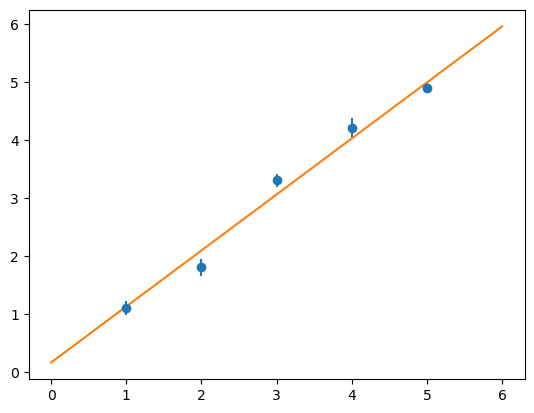

In [10]:
plt.errorbar(x, y, sigy, fmt='o')
xgrid = np.linspace(0, 6, 1000)
plt.plot(xgrid, model(xgrid, *thetahat), c='#ff7f0e')

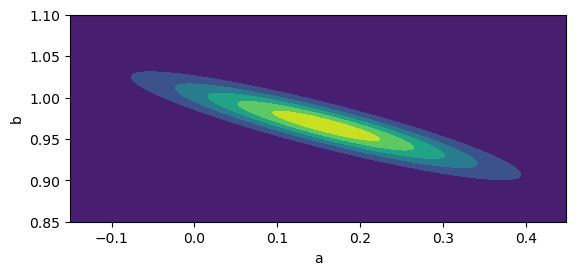

In [11]:
# Borrowing this cell from FitLline n.b.

# For m = 2 dimensions, you need to create a grid of (x,y) values,
# which you can compute the PDF on.

x, y = np.mgrid[-0.15:0.45:0.001, 0.85:1.1:0.001]
pos  = np.dstack((x, y))

pdf  = stats.multivariate_normal.pdf(pos, mean=thetahat, cov=thetacov)

fig = plt.figure()
ax  = fig.add_subplot()
ax.contourf(x, y, pdf)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_aspect('equal')  # plot with equal axes

Let's now solve this problem using the `emcee` package.

In [12]:
import emcee

In [13]:
def log_prior(theta):
    return 1.0

In [14]:
def log_like(theta, x, y, sigy):
    a, b = theta
    y_model = a + b*x
    return -0.5*np.sum(((y-y_model)/sigy)**2) - 0.5*np.sum(np.log(2*np.pi*sigy*sigy))

In [15]:
def log_posterior(theta, x, y, sigy):
    return log_prior(theta) + log_like(theta, x, y, sigy)

In [16]:
# Reload data (just in case it got messed up)
x     = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y     = np.array([1.1, 1.8, 3.3, 4.2, 4.9])
sigy  = np.array([0.12, 0.15, 0.11, 0.18, 0.09])

In [17]:
nparams  = 2      # number of parameters theta=(a,b)
nwalkers = 50     # number of independent walkers
nburn    = 1000   # number of burn-in steps to throw out (later)
nsteps   = 2000   # number of total steps including burn in
starting_guesses = np.random.rand(nwalkers, nparams)  # starting guesses for the walkers

In [18]:
#starting_guesses

This command sets up the sampler with the desired parameters and log_posterior.

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=[x, y, sigy])

In [20]:
# You can watch the progress if you install the `tqdm` package.
sampler.run_mcmc(starting_guesses, nsteps) #, progress=True)

State([[-0.01852924  1.00137262]
 [ 0.15471997  0.99901733]
 [ 0.2654267   0.93477812]
 [ 0.26787162  0.94064355]
 [ 0.12347419  0.98743389]
 [ 0.13236879  0.97311031]
 [ 0.21368486  0.94490451]
 [-0.05490387  1.04135954]
 [ 0.1313505   0.9920208 ]
 [ 0.21605247  0.96014253]
 [ 0.0442653   0.977714  ]
 [-0.00983062  1.0310983 ]
 [ 0.22743279  0.95260886]
 [ 0.16679784  0.94292345]
 [ 0.22702362  0.93956075]
 [ 0.07578511  0.98504093]
 [ 0.11944034  0.98838147]
 [ 0.12131737  0.95703232]
 [ 0.23741423  0.97788965]
 [-0.02235825  1.01705081]
 [ 0.0519339   1.01311845]
 [ 0.00360607  0.99882209]
 [ 0.02204473  0.98081992]
 [ 0.29168879  0.92991913]
 [ 0.18812924  0.96073413]
 [ 0.02078724  1.01706524]
 [ 0.10773022  0.96310676]
 [ 0.13460974  0.97503141]
 [ 0.03931954  1.00912601]
 [ 0.11837381  1.00606822]
 [ 0.03170174  1.01418526]
 [ 0.19532034  0.9583015 ]
 [ 0.24068367  0.95632101]
 [ 0.00879714  0.98090437]
 [ 0.27924738  0.91277333]
 [ 0.26640233  0.94399284]
 [ 0.40550655  0.89856

`sampler.chain` is an array of dimensions `(nwalkers, nsteps, nparams)`.  Let's cut out the burn-in steps and join the the walkers into an array of dimensions `(nwalkers*(nsteps-nburn), nparams)`.

In [21]:
samples = np.array(sampler.chain[:, nburn:, :])
print(samples.shape)
samples = samples.reshape(-1, nparams)
print(samples.shape)

(50, 1000, 2)
(50000, 2)


In [22]:
print(samples)

[[0.05638749 0.9754506 ]
 [0.08958178 0.97303423]
 [0.11313854 0.96837137]
 ...
 [0.10552153 0.95603283]
 [0.10552153 0.95603283]
 [0.107564   0.95456785]]


Text(0, 0.5, 'b')

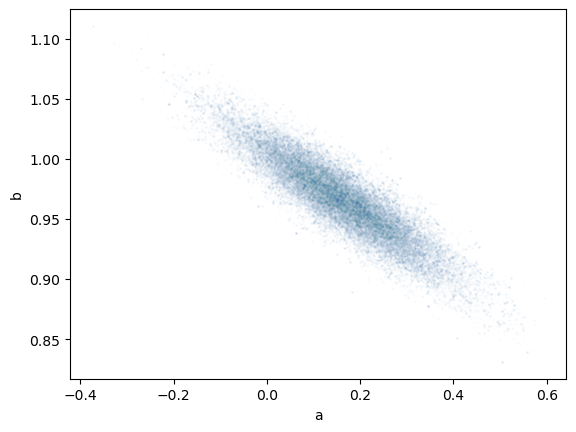

In [23]:
# plot the chains as a scatter plot
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.01, s=1)
plt.xlabel('a')
plt.ylabel('b')

In [24]:
# acceptance fractions of each walker
sampler.acceptance_fraction

array([0.7095, 0.703 , 0.714 , 0.719 , 0.708 , 0.7235, 0.725 , 0.7345,
       0.7475, 0.7125, 0.7055, 0.736 , 0.7215, 0.7355, 0.7015, 0.703 ,
       0.7225, 0.7   , 0.7225, 0.703 , 0.7105, 0.6975, 0.7005, 0.708 ,
       0.7325, 0.724 , 0.7245, 0.7045, 0.725 , 0.7335, 0.707 , 0.7065,
       0.7425, 0.7055, 0.709 , 0.7035, 0.6985, 0.699 , 0.7045, 0.7305,
       0.712 , 0.7105, 0.7165, 0.695 , 0.6975, 0.6895, 0.703 , 0.709 ,
       0.71  , 0.728 ])

In [25]:
asample = samples[:,0]
bsample = samples[:,1]

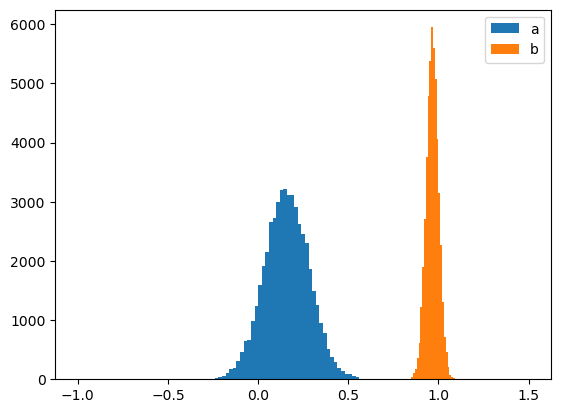

In [26]:
ahist = plt.hist(asample, range=[-1,1], bins=100, label='a')
bhist = plt.hist(bsample, range=[0.5,1.5], bins=100, label='b')
plt.legend()

In [27]:
samples[:,0].shape

(50000,)

In [28]:
print('a = %8.4f +/- %8.4f' % (np.mean(asample), np.std(asample)))
print('b = %8.4f +/- %8.4f' % (np.mean(bsample), np.std(bsample)))
# full covariance matrix
print(np.cov(samples[:,0], samples[:,1]))

a =   0.1587 +/-   0.1236
b =   0.9665 +/-   0.0343
[[ 0.01528559 -0.00382214]
 [-0.00382214  0.00117799]]


In [29]:
# from the matrix solution
print('a = %8.4f +/- %8.4f' % (thetahat[0], np.sqrt(thetacov[0,0])))
print('b = %8.4f +/- %8.4f' % (thetahat[1], np.sqrt(thetacov[1,1])))
print('cov_ab = %8.5f' % thetacov[0,1])

a =   0.1590 +/-   0.1259
b =   0.9659 +/-   0.0349
cov_ab = -0.00398


Note - the target posterior, in principle, can be any PDF and it doesn't have to contain a likelihood (i.e., comparisons of model with data).  Here we take one that consists of two multivariate gaussians with means and covariance matrices given by $$\mu_1 = \begin{pmatrix} -1 \\ -1\end{pmatrix}, \Sigma_1 = \begin{pmatrix} 1 & -0.8 \\ -0.8 & 1\end{pmatrix}$$ $$\mu_2 = \begin{pmatrix} 1 \\ 2\end{pmatrix}, \Sigma_2 = \begin{pmatrix} 1.5 & 0.6 \\ 0.6 & 0.8\end{pmatrix}$$

In [30]:
def log_posterior2(theta):
    x, y = theta
    g1 = stats.multivariate_normal.pdf((x,y), [-1,-1], [[1,-0.8],[-0.8,1]])
    g2 = stats.multivariate_normal.pdf((x,y), [1,2], [[1.5,0.6],[0.6,0.8]])
    return np.log(g1+g2)

In [31]:
nparams   = 2    # number of parameters
nwalkers = 50
nburn    = 1000
nsteps   = 2000  # 2000 will result in error when you call get_autocorr_time()
starting_guesses = np.random.rand(nwalkers, nparams)

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior2) #, args=[x, y, sigy])

In [33]:
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[ 0.85979251  0.81228439]
 [ 1.99687907  3.46156513]
 [ 0.16482658  1.93980619]
 [ 1.6633696   1.89643594]
 [ 0.38631621  0.15714301]
 [ 0.12670867 -1.77524804]
 [ 1.00517737  2.43137199]
 [-1.71654268 -0.22000673]
 [-0.50476513 -0.71249989]
 [ 0.35993988  2.67403512]
 [ 0.83314738  2.4680277 ]
 [ 1.25486213  2.39492523]
 [-0.04724631  2.31722758]
 [-0.64183394 -1.86973405]
 [-1.51432531 -1.11604199]
 [ 0.37097725 -2.3444759 ]
 [ 1.75545034  2.71671507]
 [ 1.4358496   1.96259819]
 [ 2.88661988  1.90518587]
 [ 1.5946137   1.75662374]
 [-0.06115119 -1.66147543]
 [ 0.17062245 -1.99605294]
 [ 1.4071412   1.70677917]
 [ 2.43842225  3.08267903]
 [ 0.4616683  -1.97399699]
 [ 1.33638741  0.79923367]
 [-1.39297387 -1.53444624]
 [ 1.51021788  2.59988607]
 [ 2.8923432   3.67306539]
 [-2.80162034  0.74469899]
 [ 1.21117931  2.76696961]
 [-0.74618713 -1.20668773]
 [-0.58808527  0.70519511]
 [ 1.01345047  3.88291264]
 [-0.76965388 -0.81723862]
 [ 0.35237616 -1.55644337]
 [ 0.06680419  1.41516

In [34]:
samples = np.array(sampler.chain[:, nburn:, :])
print(samples.shape)
samples = samples.reshape(-1, nparams)
print(samples.shape)

(50, 1000, 2)
(50000, 2)


Text(0, 0.5, 'y')

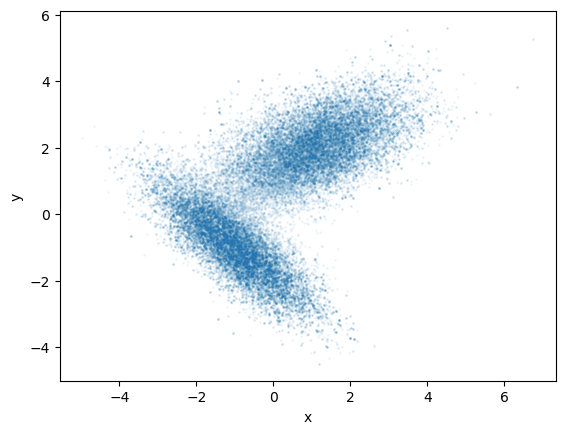

In [35]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.05, s=1)
plt.xlabel('x')
plt.ylabel('y')

In [36]:
sampler.acceptance_fraction

array([0.5965, 0.6025, 0.5945, 0.6125, 0.5935, 0.6165, 0.578 , 0.61  ,
       0.6005, 0.609 , 0.6075, 0.59  , 0.615 , 0.6   , 0.585 , 0.579 ,
       0.5745, 0.5975, 0.589 , 0.595 , 0.586 , 0.594 , 0.603 , 0.562 ,
       0.594 , 0.6015, 0.593 , 0.628 , 0.5715, 0.579 , 0.579 , 0.5865,
       0.5925, 0.5935, 0.591 , 0.6055, 0.5905, 0.5925, 0.586 , 0.5965,
       0.561 , 0.606 , 0.5795, 0.592 , 0.5955, 0.592 , 0.5735, 0.617 ,
       0.576 , 0.5805])

## Some advanced features and usage

`emcee` has several implementations of "moves" - i.e., how the MCMC decides how to take steps:

https://emcee.readthedocs.io/en/stable/user/moves/

The default is the so-called "stretch move" method from Goodman & Weare (2010).  There are other implementations that work better in certain situations.  Metropolis-Hastings is also one of the options.

(0.0, 5000.0)

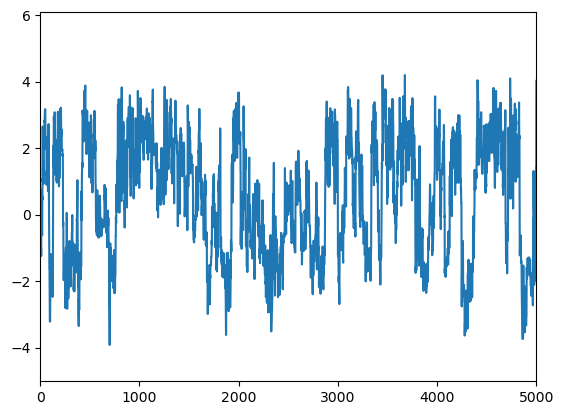

In [37]:
plt.plot(samples[:,1])
plt.xlim([0,5000])

You can see that the chain jumps between the two gaussians with a long-ish time scale (i.e., it spends some time in one before it jumps to the other).  Although it is not too important in this case since we can trivially run longer chains, but in other applications where runtime comes with a premium, you want to avoid such behavior as much as possible.

This can be quantified by what's called an autocorrelation time - the average number of steps between independent samples.  We want to reduce this as much as possible.

In [38]:
# these are the average numbers of steps in (a,b) between independent samples.
print(sampler.get_autocorr_time())

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [48.89315347 62.76975249]

Here, `emcee` is giving you and error to tell you that your chains are, in fact, not long enough given our long autocorrelation time.

Let's implement a different set of moves a suggested by in the `emcee` documentation:

https://emcee.readthedocs.io/en/stable/tutorials/moves/

a mixture of `DEMove` (differential evolution) and `DESnookerMove` (another variant).  `emcee` allows you to specify what fraction to use for each mover.

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior2,
                                moves=[
                                   (emcee.moves.DEMove(), 0.8),        # 80% DE
                                   (emcee.moves.DESnookerMove(), 0.2)  # 20% DE snooker
                                ])

In [40]:
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

You must install the tqdm library to use progress indicators with emcee
/var/folders/d2/c2qgnrsx7pq61vp0fh3966zh0000gr/T/ipykernel_35441/4286752579.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(g1+g2)


State([[ 0.38747944 -1.46005674]
 [ 1.69389368  2.7696858 ]
 [-3.4961724   0.68189778]
 [-3.18551276  1.43381588]
 [ 3.20334183  3.0162417 ]
 [ 0.54392943  1.70206392]
 [ 2.94691391  3.8101893 ]
 [ 0.8041988   2.79107585]
 [-2.11879508 -1.16474567]
 [ 0.79871158  0.21624701]
 [-0.70030819 -0.15146413]
 [ 1.23197307  3.36764075]
 [ 0.92120312  2.00522526]
 [ 0.5184925   2.62924695]
 [ 0.21332205 -1.88436273]
 [ 0.83724828  1.95572794]
 [-0.62083487 -1.86682606]
 [-0.53232988 -0.90667621]
 [ 1.17243325  3.08187484]
 [ 0.02925501 -2.04118039]
 [-0.57173066 -0.80724717]
 [-0.41968942  1.47772549]
 [-3.62995939  0.93053314]
 [ 0.03567732 -1.09697755]
 [ 1.17868317  1.92737474]
 [-1.85430602  0.01437284]
 [-2.18642138 -0.55389543]
 [ 0.01657189  1.13989307]
 [ 0.81729493  2.39983978]
 [-1.42028453 -0.91398968]
 [ 0.71800905  1.86066281]
 [-0.18076889 -1.48935087]
 [-0.67406636  0.6578714 ]
 [-0.47992236 -0.91200083]
 [-0.59540286 -0.2975453 ]
 [ 0.37127813 -2.34403473]
 [-2.69136083  0.44227

In [41]:
samples = np.array(sampler.chain[:, nburn:, :])
print(samples.shape)
samples = samples.reshape(-1, nparams)
print(samples.shape)

(50, 1000, 2)
(50000, 2)


Text(0, 0.5, 'y')

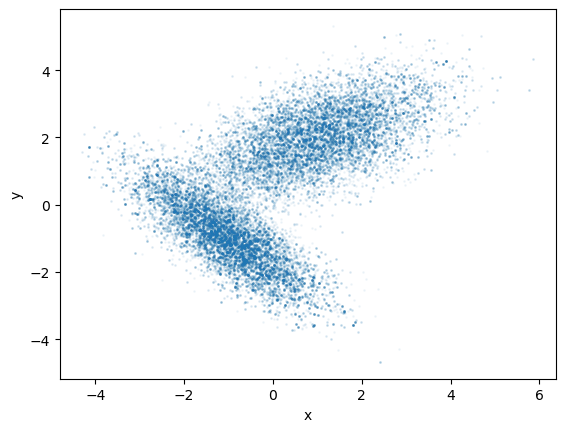

In [42]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.05, s=1)
plt.xlabel('x')
plt.ylabel('y')

In [43]:
sampler.acceptance_fraction

array([0.251 , 0.246 , 0.233 , 0.2475, 0.231 , 0.254 , 0.232 , 0.249 ,
       0.243 , 0.2455, 0.2435, 0.254 , 0.242 , 0.228 , 0.2445, 0.2435,
       0.243 , 0.2665, 0.231 , 0.2435, 0.2535, 0.233 , 0.2285, 0.2445,
       0.237 , 0.2255, 0.2385, 0.2635, 0.2375, 0.249 , 0.2415, 0.232 ,
       0.2225, 0.228 , 0.2325, 0.2345, 0.224 , 0.237 , 0.252 , 0.26  ,
       0.2615, 0.256 , 0.239 , 0.234 , 0.231 , 0.249 , 0.2245, 0.2315,
       0.26  , 0.2525])

(0.0, 5000.0)

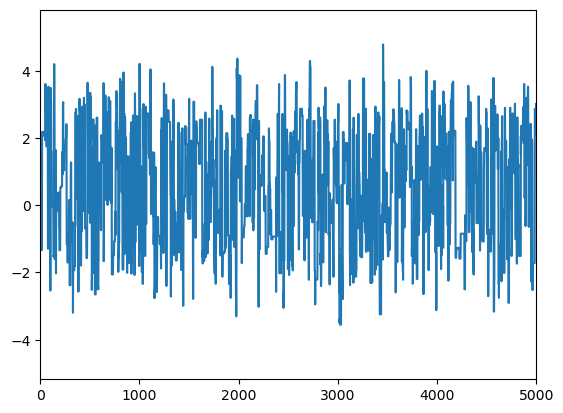

In [44]:
plt.plot(samples[:,1])
plt.xlim([0,5000])

This looks a little better.  The walker doesn't spend too much time in one gaussian before jumping to the next.

In [45]:
# these are the average numbers of steps in (a,b) between independent samples.
print(sampler.get_autocorr_time())

[12.87188837 15.76815156]
